# Visual-based road detection

* [Work Description](files/intro-docs/VCOM_2015-2016_Trabalho_1_v02.pdf)

This project focus on finding and extracting delimiter features (edges) present on a road. This ability is of great importance in computer vision field, namely in autonomous driver applications.

## Process
* Sharpen image
    * **e.g.** CLAHE
* Reduce noise (assume Gaussian noise)
    * Preserve the edges
* Highlight edges
    * **e.g.** Canny
* Extract lines
* Find Intersection point


### Possible improvements
* Add Gaussian noise and test performance of the algorithm

*Note:* test with different image representations, in order to extract channels where the image is easier to parse.

In [233]:
import cv2

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

# Load Images Dataset

In [234]:
img = cv2.imread("pics/road-07.jpg")
img = cv2.resize(img, (600, 400))

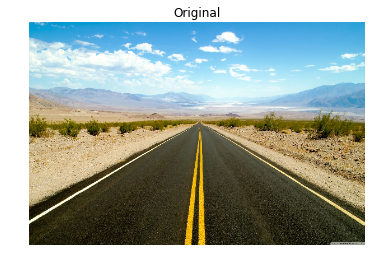

In [235]:
img_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off'); plt.title('Original'); plt.imshow(img_show)

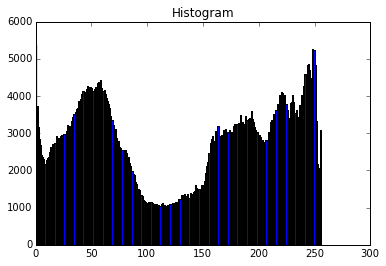

In [236]:
plt.title('Histogram'); _ = plt.hist(img_show.ravel(), 256, [0, 256])

# Image Contrast Enhancement

convert to HLS, in order to extract Intensity (in this case Lightness)

In [237]:
img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

## Histogram Equalization

In [238]:
img_he = img_hls.copy()
img_he[:, :, 1] = cv2.equalizeHist(img_he[:, :, 1])

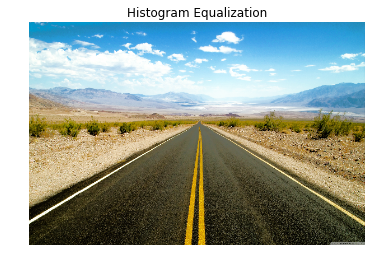

In [239]:
img_show = cv2.cvtColor(img_he, cv2.COLOR_HLS2RGB)
plt.axis('off'); plt.title('Histogram Equalization'); plt.imshow(img_show)

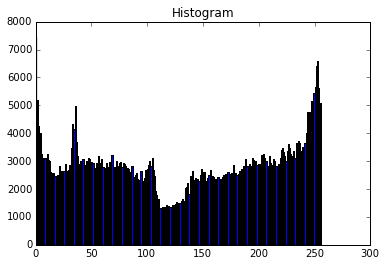

In [240]:
plt.title('Histogram'); _ = plt.hist(img_show.ravel(), 256, [0, 256])

## CLAHE

In [241]:
img_clahe = img_hls.copy()
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
img_clahe[:, :, 1] = clahe.apply(img_clahe[:, :, 1])

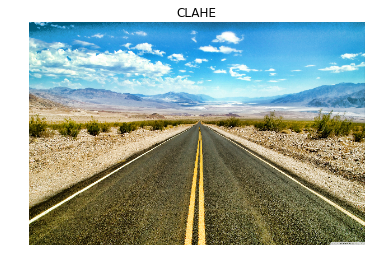

In [242]:
img_show = cv2.cvtColor(img_clahe, cv2.COLOR_HLS2RGB)
plt.axis('off'); plt.title('CLAHE'); plt.imshow(img_show)

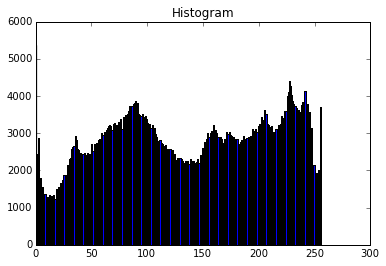

In [243]:
plt.title('Histogram'); _ = plt.hist(img_show.ravel(), 256, [0, 256])

We'll use CLAHE output, cause the histogram obtained is not so sensible to high lightning.

In [244]:
img_sharp = img_clahe
img_sharp = cv2.cvtColor(img_sharp, cv2.COLOR_HLS2BGR)

# Noise Reduction

We use Bilateral Filtering for noise reduction. This way, the textures are removed, but the edges are kept intact.

In [245]:
img_bil = cv2.bilateralFilter(img_sharp, 10, 75, 500)
img_bil_ori = cv2.bilateralFilter(img, 5, 75, 500)

In [246]:
img_show1 = cv2.cvtColor(img_bil, cv2.COLOR_BGR2RGB)
img_show2 = cv2.cvtColor(img_bil_ori, cv2.COLOR_BGR2RGB)

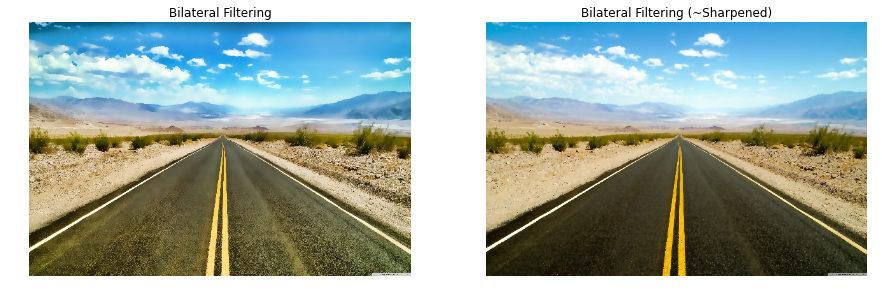

In [247]:
plt.figure(figsize=(15, 10))
plt.subplot(121); plt.axis('off'); plt.title('Bilateral Filtering'); plt.imshow(img_show1)
plt.subplot(122); plt.axis('off'); plt.title('Bilateral Filtering (~Sharpened)'); plt.imshow(img_show2)

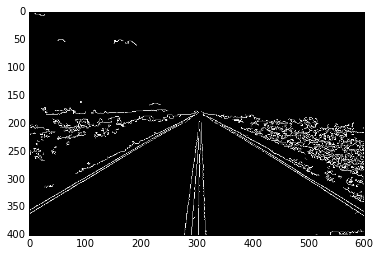

In [248]:
img_hls = cv2.cvtColor(img_bil_ori, cv2.COLOR_BGR2HLS)

img_clahe_sharp = img_hls.copy()
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
img_clahe_sharp[:, :, 1] = clahe.apply(img_clahe_sharp[:, :, 1])
img_clahe_sharp = cv2.Canny(img_clahe_sharp[:, :, 1], 200, 600)

plt.imshow(img_clahe_sharp, cmap='gray')

## Edges thresholding

In [249]:
original_img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
sharp_img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
denoise_img_hls = cv2.cvtColor(img_bil, cv2.COLOR_BGR2HLS)
denoise_img_hls_ori = cv2.cvtColor(img_bil, cv2.COLOR_BGR2HLS)

In [250]:
edges_original_img = cv2.Canny(original_img_hls[:, :, 1], 150, 300, L2gradient=True)
edges_sharp_img = cv2.Canny(sharp_img_hls[:, :, 1], 150, 300, L2gradient=True)
edges_denoise_img = cv2.Canny(denoise_img_hls[:, :, 1], 200, 600, L2gradient=True)

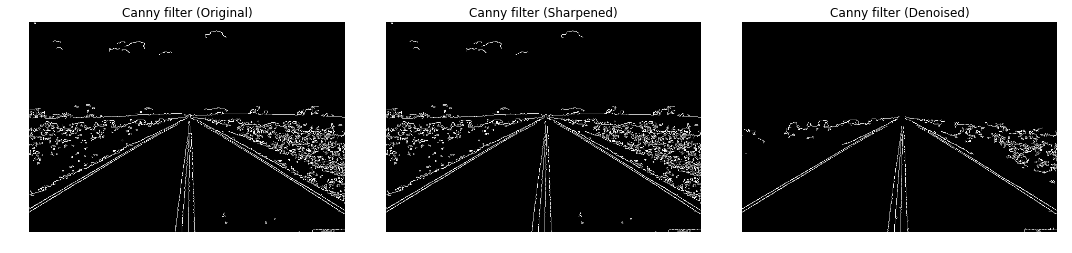

In [251]:
plt.figure(figsize=(15, 10))
plt.subplot(131); plt.axis('off'); plt.title("Canny filter (Original)"); plt.imshow(edges_original_img, cmap='gray')
plt.subplot(132); plt.axis('off'); plt.title("Canny filter (Sharpened)"); plt.imshow(edges_sharp_img, cmap='gray')
plt.subplot(133); plt.axis('off'); plt.title("Canny filter (Denoised)"); plt.imshow(edges_denoise_img, cmap='gray')
plt.tight_layout()

## Extract lines: Hough Algorithm

### Simple Hough Algorithm

In [276]:
img_bil_s = img_bil.copy()
lines = cv2.HoughLines(edges_denoise_img, 1, np.pi/180.0, 120)
for rho, theta in lines[:, 0, :]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img_bil_s, (x1, y1), (x2, y2), (0, 0, 255), 2)

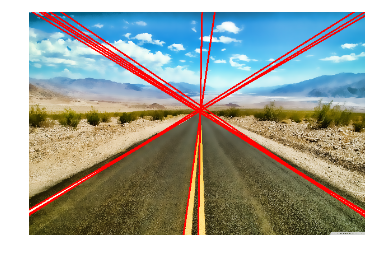

In [277]:
img_show = cv2.cvtColor(img_bil_s, cv2.COLOR_BGR2RGB)
plt.axis('off'); plt.imshow(img_show)

### Probabilistic Hough Algorithm

In [278]:
img_bil_p = img_bil.copy()

minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(denoise_img_hls, 1, np.pi/180, 100, minLineLength, maxLineGap)
for x1,y1,x2,y2 in lines[:, 0, :]:
    cv2.line(img_bil_p, (x1, y1), (x2, y2), (0, 255, 0), 2)

error: /home/travis/miniconda/conda-bld/work/opencv-3.0.0/modules/imgproc/src/hough.cpp:424: error: (-215) image.type() == CV_8UC1 in function HoughLinesProbabilistic


In [ ]:
img_show = cv2.cvtColor(img_bil_p, cv2.COLOR_BGR2RGB)
plt.axis('off'); plt.imshow(img_show)